# Kaggle - What's Cooking

The goal of this analysis is to determine the cuisine of a recipe based on its ingredients.  The data is in the form of a json file, where each element is a recipe with ingredients.  This is an NLP project so we'll be using ML techniques designed for language and text.

In [69]:
# Load modules

import json
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plot
import seaborn as sns; sns.set()

from scipy.stats import describe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

## Data Exploration

In [2]:
# Load data

with open('C:\\Users\\Colleen\\Documents\\Kaggle_Whats_Cooking\\data\\train.json', 'r') as f:
    train_data = json.load(f)
print 'Number of recipes: ' + str(len(train_data))

Number of recipes: 39774


The data is in the form of a list of dictionaries, containing the cuisine, an ID and the list of ingredients:

In [3]:
train_data[0]

{u'cuisine': u'greek',
 u'id': 10259,
 u'ingredients': [u'romaine lettuce',
  u'black olives',
  u'grape tomatoes',
  u'garlic',
  u'pepper',
  u'purple onion',
  u'seasoning',
  u'garbanzo beans',
  u'feta cheese crumbles']}

The distribution of cusine samples in the training set is shown below.  We have an unbalanced class situation, so we'll need to be aware of that when we assess accuracy of models.

In [20]:
counter = collections.Counter([x['cuisine'] for x in train_data])
cusine_dist = pd.DataFrame({'cuisine': counter.keys(), 'count': counter.values()})
num_ing = [len(x['ingredients']) for x in train_data]

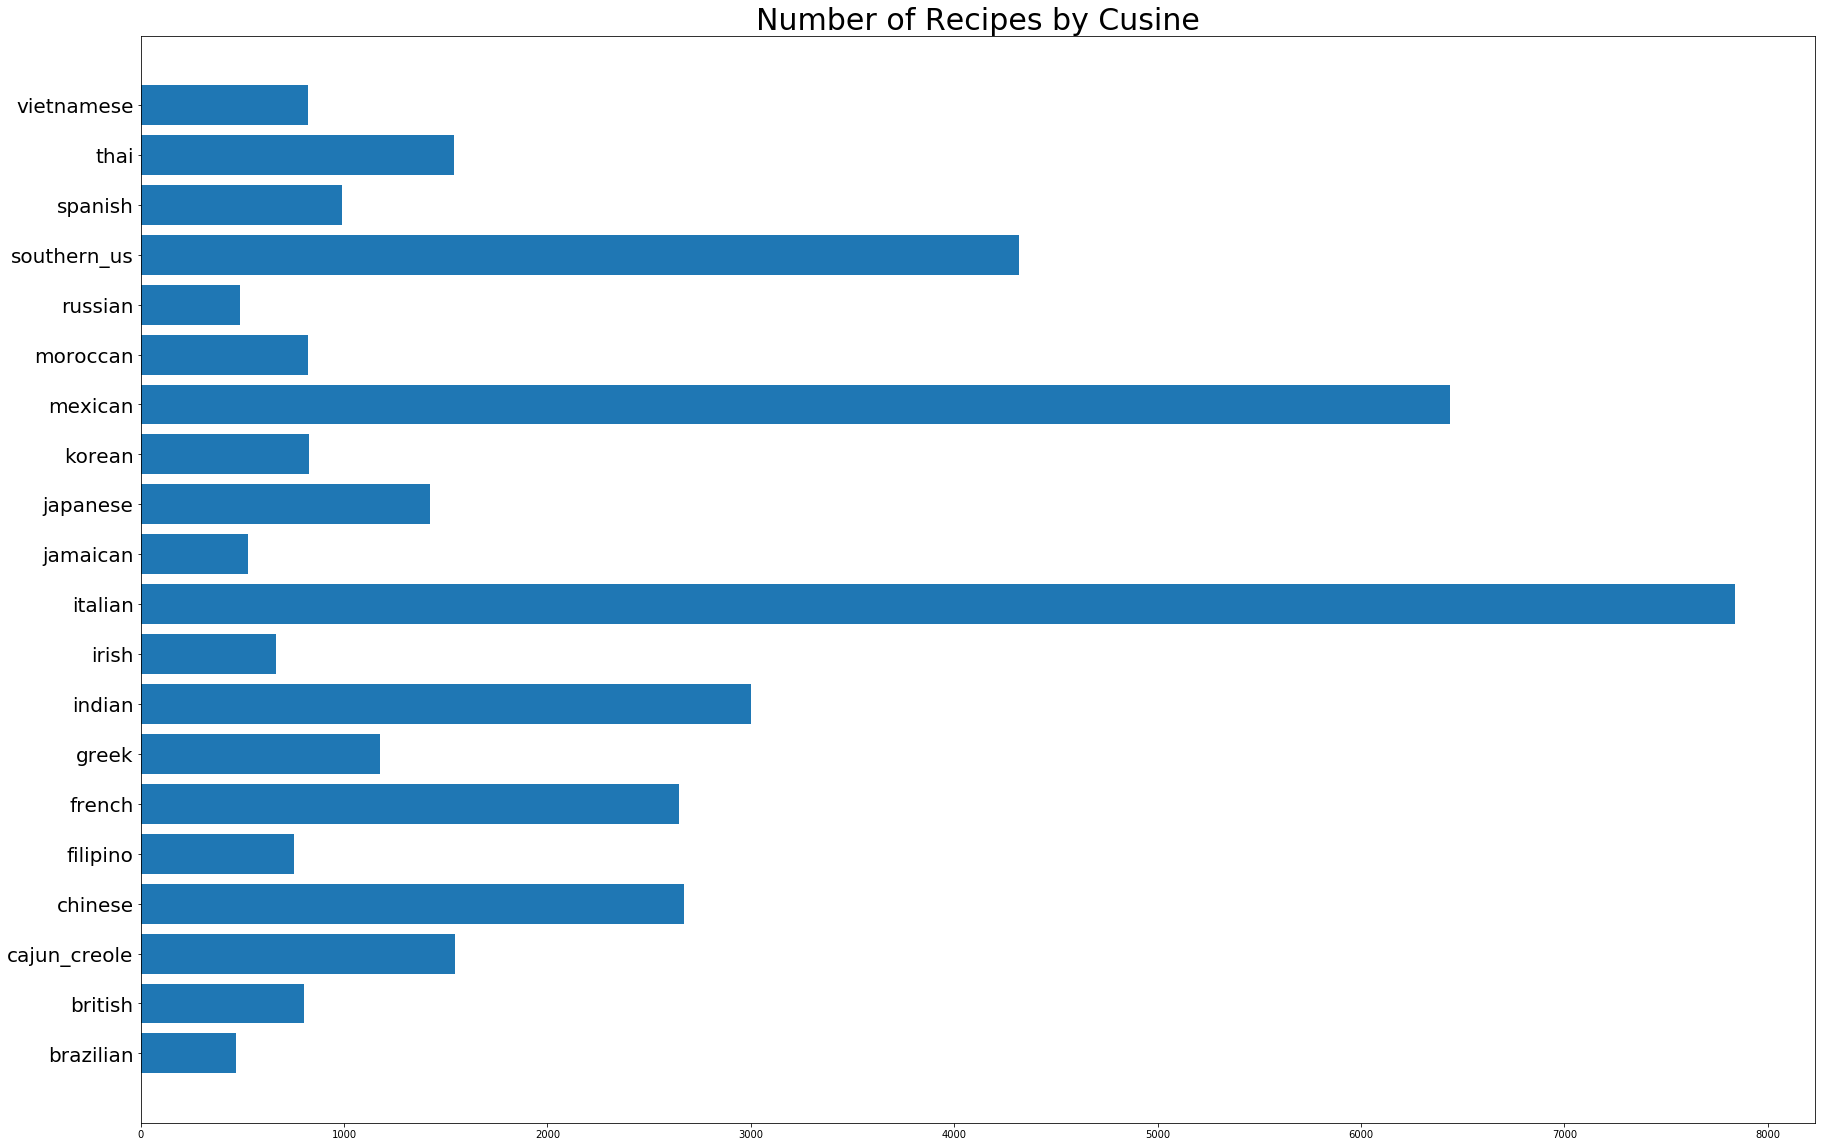

In [24]:
plot.figure(1)
plot.figure(figsize = (30,20))
plot.rc('ytick',labelsize=20)
plot.barh(cusine_dist['cuisine'], cusine_dist['count'])
plot.title('Number of Recipes by Cusine', fontsize = 30)

#plot.rcParams.update({"figure.figsize": [30,20]})
plot.show()
plot.clf()
plot.cla()
plot.close()

The following is the distribution of number of ingredients in each recipe.  There are no recipes with 0 ingredients.  One has 65 which could be an outlier.  We'll keep an eye on it.

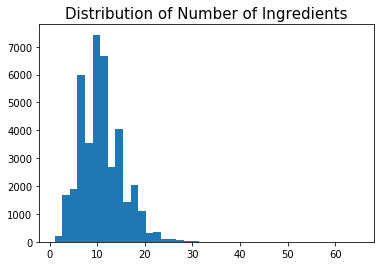

In [26]:
plot.figure(2)
plot.rc('ytick',labelsize=10)
plot.hist(num_ing, bins=40)
plot.title('Distribution of Number of Ingredients', fontsize = 15)
plot.show()

In [27]:
print 'Min num ingredients: ' + str(min(num_ing))
print 'Max num ingredients: ' + str(max(num_ing))

Min num ingredients: 1
Max num ingredients: 65


In general, the data is in the form of a list of terms for each recipe.  The ordering of the ingredients of a recipe likely doesn't affect the cuisine - ingredients are ordered based on the cooking methods or the ingredient type.  So we'll start with a simple bag-of-words model, using a multinomial naive bayes classifier. We'll also use weighted F1 score to assess performance, both training and test score.

In [44]:
# Create bag of words

docs = [' '.join([x.replace(' ', '') for x in y['ingredients']]) for y in train_data]
labels = [y['cuisine'] for y in train_data]
vectorizer = CountVectorizer()
bag_words = vectorizer.fit_transform(docs).todense()
vocab = vectorizer.vocabulary_

In [48]:
# Split into new training and test test, using stratified sampling

X_train, X_test, y_train, y_test = train_test_split(bag_words, labels,
                                                    stratify=labels, 
                                                    test_size=0.25)

In [62]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
validated = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'f1_weighted')
validated
#clf.fit(X_train, y_train)
#y_tr_pred = clf.predict(X_train)

array([ 0.70775151,  0.69451952,  0.71867836,  0.70653521,  0.7123834 ,
        0.71892735,  0.71514428,  0.70189938,  0.7197692 ,  0.71189022])

In [175]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
print 'training score: ' + str(f1_score(y_train, y_train_pred, average = 'weighted', labels = lab_order))
print 'test score: ' + str(f1_score(y_test, y_pred, average = 'weighted', labels = lab_order))

training score: 0.760452341938
test score: 0.709216920847


The performance of this model isn't amazing, but its a good starting point.  We'll look at a confusion matrix, but with the rows normalized, to get an idea of the distribution of miss-classified samples. (shown below)  

In [157]:
lab_order = np.unique(labels)
mat = confusion_matrix(y_pred, y_test, labels = lab_order)
norm_conf = pd.DataFrame(mat).div(pd.DataFrame(mat).sum(axis=1), axis=0) * 100.0
norm_conf.columns = lab_order
norm_conf.index = lab_order

In [159]:
from sklearn.metrics import f1_score
df = pd.DataFrame({'accuracy': f1_score(y_test, y_pred, average = None, labels = lab_order)})
df.index = lab_order
df = pd.concat([df, norm_conf], 1)

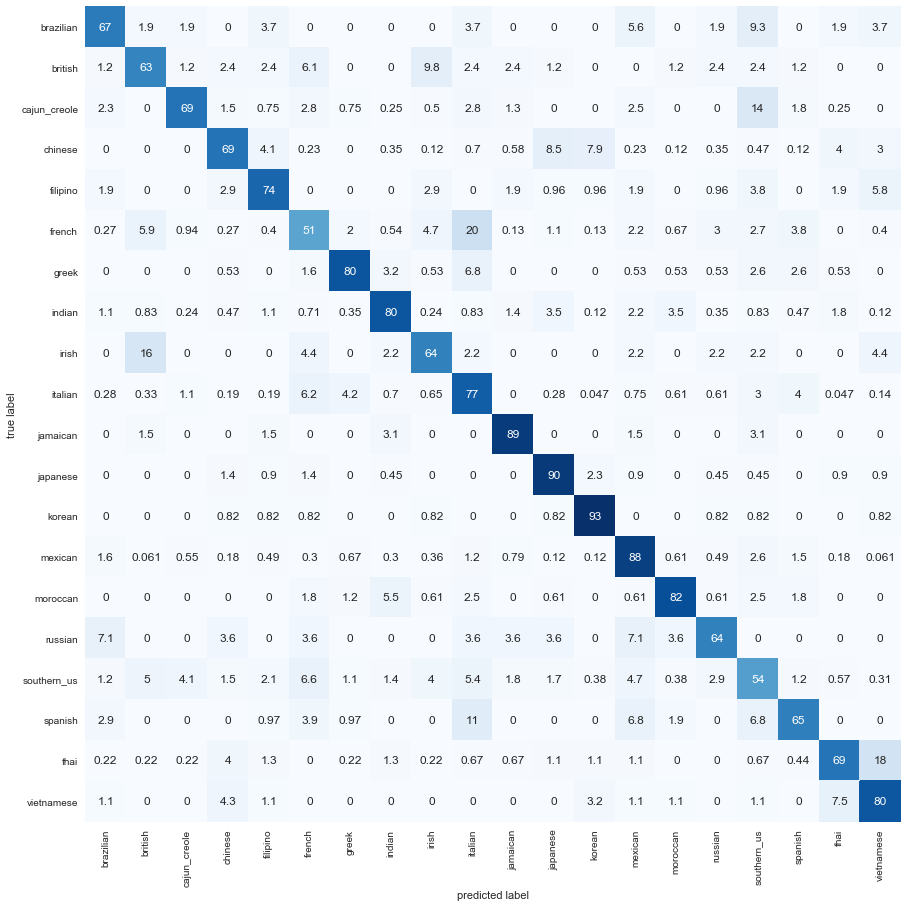

In [167]:
plot.figure(3, figsize = (15,15))
sns.heatmap(norm_conf, square=True, annot=True, cbar=False, cmap = "Blues",
           xticklabels = lab_order, yticklabels = lab_order)
plot.ylabel('true label')
plot.xlabel('predicted label');
plot.show()

The main "mix-ups" are:

1. 9.8% of "British" miss-classified as "Irish"
2. 14% of "Cajon Creole" miss-classified as "Southern US"
3. 8.5% and 7.9% of "Chinese" miss-classified as "Japanese" and "Korean" respectively
4. 20% of "French" miss-classified as "Italian"
5. 16% of "Irish" miss-classified as "British"
6. 7.1% of "Russian" miss-classified as "Brazilian" and "Mexican"
7. 5%, 6.6% and 5.4% of "Southern US" miss-classified as "British", "French" and "Italian" respectively
8. 11%, 6.8% and 6.8% of "Spanish" miss-classified as "Italian", "Mexian" and "Southern US" respectively
9. 18% of "Thai" miss-classified" as "Vietnamese"

A lot of these make sense since, for example, Thai and Vietnamese cuisines are quite similar in some respects and thus use similar ingredients.

We can also look at the top/bottom predictive 'features' or words for each class.  Below are the top 10 words for each cusine, and the top bottom words:

In [170]:
top_feats_cuisine = dict(zip(np.sort(lab_order),
                            [list(pd.DataFrame(zip(vectorizer.get_feature_names(), x))\
                             .sort_values(1, ascending = False).iloc[range(10), 0]) for x in clf.coef_]))
pd.DataFrame(top_feats_cuisine).T

,0,1,2,3,4,5,6,7,8,9
brazilian,salt,onions,oliveoil,lime,garliccloves,water,garlic,sugar,cachaca,pepper
british,salt,all,purposeflour,butter,milk,unsaltedbutter,eggs,sugar,onions,bakingpowder
cajun_creole,salt,onions,garlic,butter,greenbellpepper,oliveoil,cajunseasoning,water,cayennepepper,all
chinese,soysauce,cornstarch,salt,sesameoil,sugar,garlic,water,greenonions,scallions,vegetableoil
filipino,salt,garlic,onions,water,soysauce,pepper,oil,sugar,carrots,groundblackpepper
french,salt,sugar,all,unsaltedbutter,purposeflour,butter,oliveoil,water,largeeggs,garliccloves
greek,salt,oliveoil,garliccloves,driedoregano,fetacheesecrumbles,groundblackpepper,freshlemonjuice,garlic,extra,virginoliveoil
indian,salt,onions,garammasala,water,garlic,groundturmeric,cuminseed,groundcumin,vegetableoil,ginger
irish,salt,butter,all,purposeflour,sugar,bakingsoda,onions,milk,bakingpowder,potatoes
italian,salt,oliveoil,garliccloves,gratedparmesancheese,garlic,groundblackpepper,extra,virginoliveoil,onions,butter


In [171]:
bot_feats_cuisine = dict(zip(np.sort(lab_order),
                            [list(pd.DataFrame(zip(vectorizer.get_feature_names(), x))\
                             .sort_values(1).iloc[range(10), 0]) for x in clf.coef_]))
pd.DataFrame(bot_feats_cuisine).T

,0,1,2,3,4,5,6,7,8,9
brazilian,10oz,passata,pasillapepper,pasillachiles,pasillachilepepper,pasilla,part,parsleysprigs,parsleyroot,parsleyflakes
british,10oz,padronpeppers,pacepicantesauce,pacechunkysalsa,paccheri,oz,oystersauce,oysters,oystermushrooms,oysterliquor
cajun_creole,10oz,orangeroughy,orangerind,orangepekoetea,orangepeel,orangemarmalade,orangeliqueur,orangejuiceconcentrate,orangeglaze,orangeextract
chinese,10oz,oats,oatmilk,oatmealcookiemix,oatmeal,oatgroats,oatflour,oatbran,nutritionalyeastflakes,nutritionalyeast
filipino,10oz,parmigiana,parmaham,parmagianoreggiano,parevemargarine,parboiledrice,paratha,paprikapaste,pappardellepasta,pappardelle
french,10oz,no,nillawafers,nigellaseeds,nigaritofu,nielsen,nidomilkpowder,niangao,ngogai,nondairymilk
greek,knorrbeefstockcubes,painaulevain,paellarice,padronpeppers,pacepicantesauce,pacechunkysalsa,paccheri,oz,oystersauce,oysters
indian,10oz,oposquash,oniontops,onionsoup,onionslices,onionsalt,oniongravy,onionflakes,onethirdlesssodiumchickenbroth,on
irish,10oz,parmigiano,parmigiana,parmesancheese,parmaham,parmagianoreggiano,parevemargarine,parboiledrice,paratha,paprikapaste
italian,zucchiniblossoms,rooster,groundpeanut,groundpecans,groundpeppercorn,groundpoppyseed,romainelettucehearts,rolledoats,roe,groundroastedsichuanpeppers


In turns out that salt, soy sauce and fish sauce are the top predictive words - as if the ingredient that gives a dish sodium, is indicative of the cuisine.  We can also see why certain recipes are misclassified - for example thai and vietnamese cuisines have many of the same top ingredients.

There are some weird words showing up in the top words - like "all" which doesn't seem to be an ingredient.  This could be contributing to the miss-classifications.  Also, some preprocessing could be done to merge features together - like "butter" and "unsaltedbutter"

The bottom ingredients also indicate that some further data cleaning is needed.  There are volume measurements that should be removed.  Also brand-specific ingredients like "knorr beef stock cubes" and "mountain dew soda" that need to be processed to remove the branding.